# Attempt 1

We are solving the following system of equations:
$$\frac{\Omega_i^k - \Omega^{k-1}_i}{\tau} - \frac{v^{k-1}\xi_i}{\gamma^{k-1}} \frac{\Omega_{i+1}^k - \Omega^{k}_{i-1}}{2h} - \frac{1}{(\gamma^{k-1} h)^2} \left(\left(\frac{\Omega^{k-1}_{i+1} + \Omega^{k-1}_{i}}{2}\right)^3(\Omega_{i+1}^k - \Omega^{k}_{i})  - \left( \frac{\Omega^{k-1}_{i} + \Omega^{k-1}_{i-1}}{2} \right)^3 (\Omega_{i}^k - \Omega^{k}_{i-1})\right) = 0$$

$$\Omega_0^k = 0$$
$$\Omega_{N-1}^k = 1$$

$$  v^k = (\Omega_{N-2}^k)^2 \frac{ \Omega_{N-3}^k}{2\gamma^{k-1} h}   $$

Let's combine the terms

$$ \Omega_{i+1}^k \left( - \frac{v^{k-1}\xi_i}{2\gamma^{k-1} h} - \frac{1}{(\gamma^{k-1} h)^2} \left(\frac{\Omega^{k-1}_{i+1} + \Omega^{k-1}_{i}}{2}\right)^3 \right)  + \Omega_i^k \left( \frac{1}{\tau} +  \frac{1}{(\gamma^{k-1} h)^2}\left(\frac{\Omega^{k-1}_{i+1} + \Omega^{k-1}_{i}}{2}\right)^3 - \frac{1}{(\gamma^{k-1} h)^2}\left( \frac{\Omega^{k-1}_{i} + \Omega^{k-1}_{i-1}}{2} \right)^3 \right) + \Omega_{i-1}^k \left( \frac{v^{k-1}\xi_i}{2\gamma^{k-1} h} -  \frac{1}{(\gamma^{k-1} h)^2} \left( \frac{\Omega^{k-1}_{i} + \Omega^{k-1}_{i-1}}{2} \right)^3 \right) = \frac{\Omega_i^{k-1}}{\tau}$$

So we'll need to solve the system of equations

$$ A(\Omega^{k-1}) \Omega^k = f(\Omega^{k-1})$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

In [98]:
N = 100
xi = np.linspace(0,1,N)
h = 1/(N-1)
W0 = np.sqrt(1 - xi)              # intitial solution of omega
g = 4                             # initial gamma
v0 = W0[N-2]**2*W0[N-3]/g/2/h     # initial velocity
t = 10**(-5)                      # time step

Text(0, 0.5, 'xi')

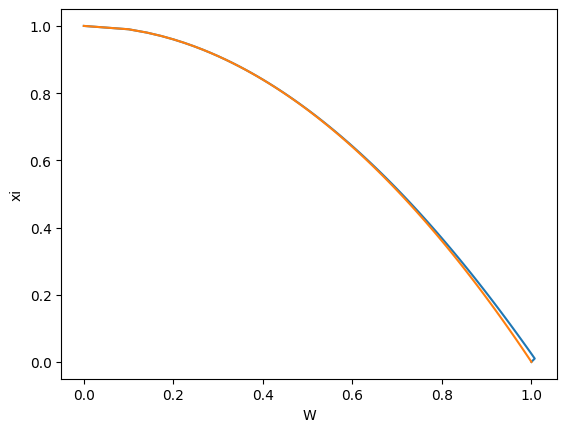

In [99]:
v_prev = v0.copy()
W_prev = W0.copy()
eps = 1
eps_v = 1

n_t = 10**5        # number of time steps
# psi0 = np.empty(n_t+1)
# psi0[0] = - ((W0[0] + W0[1])/2)**3/g*(-W0[0] + W0[1])/h
# t0 = 10**(-3)
# time = [t0]

for j in range(n_t):                # time loop
    # gs.append(g)
    # ts.append(j*t)
    while(eps_v > 10**(-2)):        # loop to approximate the velocity v
        while(eps > 10**(-2)):      # loop to approximate the opening omega
            # upper diagonal
            a1 = np.zeros(N-1)
            a1[1:-1] = - v_prev/g*xi[1:-2]/2/h - 1/(g*h)**2*((W_prev[1:-2] + W_prev[2:-1])/2)**3

            # main diagonal
            a0 = np.ones(N)
            a0[1:-1] = 1/t + 1/(g*h)**2*((W_prev[1:N-1] + W_prev[2:])/2)**3 - 1/(g*h)**2*((W_prev[0:N-2] + W_prev[1:N-1])/2)**3

            # lower diagonal
            a_1 = np.zeros(N-1)
            a_1[:-1] = v_prev/g*xi[1:-1]/2/h - 1/(g*h)**2*((W_prev[:-2] + W_prev[1:-1])/2)**3

            # right hand side
            f = np.zeros(N)
            f[0] = 1
            f[-1] = 0
            f[1:-1] = W_prev[1:-1]/t

            # making matrix and solving the system
            k = [a_1,a0, a1]
            offset = [-1,0,1]
            A = diags(k,offset, format = 'csr')
            W = spsolve(A, f)

            # error of solution
            eps = np.sqrt(((W - W_prev)**2).mean())
            
            W_prev = W.copy()

        # getting new velocity
        v = W_prev[N-2]**2*W_prev[N-3]/g/2/h
        eps_v = np.abs(v - v_prev)
        v_prev = v.copy()

    # getting new gamma
    g = g + v_prev*t
    # time.append(time[j] + t)
    # psi0[j+1] = - ((W[0] + W[1])/2)**3/g*(-W[0] + W[1])/h

plt.figure()
plt.plot(W_prev, xi)
plt.plot(W0, xi)
plt.xlabel('W')
plt.ylabel('xi')

# Attempt 2
We are solving the following system of equations:
$$\frac{\Omega_i^k - \Omega^{k-1}_i}{\tau} - \frac{v^{k-1}\xi_i}{\gamma^{k-1}} \frac{\Omega_{i+1}^k - \Omega^{k}_{i-1}}{2h} - \frac{1}{(\gamma^{k-1} h)^2} \left(\left(\frac{\Omega^{k-1}_{i+1} + \Omega^{k-1}_{i}}{2}\right)^3(\Omega_{i+1}^k - \Omega^{k}_{i})  - \left( \frac{\Omega^{k-1}_{i} + \Omega^{k-1}_{i-1}}{2} \right)^3 (\Omega_{i}^k - \Omega^{k}_{i-1})\right) = 0$$

$$\Omega_0^k = 0$$
$$\Omega_{N-1}^k = 1$$

$$ v^k = (\Omega_{N-2}^k)^2 \frac{ \Omega_{N-3}^k}{2\gamma^{k-1} h}  $$

Let's introduce new variable $\Delta \Omega_i = \Omega_i^k -  \Omega_i^{k-1} $ and rewrite equations. Let $\Omega_i^0 = \Omega_i^{k-1}$.

$$ \Delta \Omega_i - \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} (\Delta \Omega_{i+1} - \Delta \Omega_{i-1}) - \frac{\tau}{(\gamma^{k-1} h)^2} \left(  \left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 (\Delta\Omega_{i+1} -\Delta \Omega_{i}) - \left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 (\Delta\Omega_{i} - \Delta\Omega_{i-1})  \right) =  \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} (\Omega_{i+1}^0 - \Omega_{i-1}^0) + \frac{\tau}{(\gamma^{k-1} h)^2}\left(  \left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 (\Omega_{i+1}^0 - \Omega_{i}^0) - \left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 (\Omega_{i}^0 - \Omega_{i-1}^0) \right)$$

Let's combine the terms

$$ \Delta \Omega_{i+1} \left( - \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} - \frac{\tau}{(\gamma^{k-1} h)^2} \left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 \right)  + \Delta \Omega_i \left( 1 +  \frac{\tau}{(\gamma^{k-1} h)^2}\left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 - \frac{\tau}{(\gamma^{k-1} h)^2}\left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 \right) + \Delta \Omega_{i-1} \left( \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} -  \frac{1}{(\gamma^{k-1} h)^2} \left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 \right) = \frac{\tau v^{k-1}\xi_i}{2\gamma^{k-1} h} (\Omega_{i+1}^0 - \Omega_{i-1}^0) + \frac{\tau}{(\gamma^{k-1} h)^2}\left(  \left(\frac{\Omega^{0}_{i+1} + \Omega^{0}_{i}}{2}\right)^3 (\Omega_{i+1}^0 - \Omega_{i}^0) - \left( \frac{\Omega^{0}_{i} + \Omega^{0}_{i-1}}{2} \right)^3 (\Omega_{i}^0 - \Omega_{i-1}^0) \right)$$

So we'll need to solve the system of equations

$$ A(\Omega^0) \Delta \Omega = f(\Omega^0)$$

In [3]:
# k_{i+1/2} = ((omega(i+1) + omega(i))/2)^3
def K(w):
    k = np.empty(w.shape[0] + 1)
    k[0] = (1 + w[0])/2
    k[-1] = w[-1]/2
    k[1:-1] = (w[:-1] + w[1:])/2
    return k**3

# psi_{k+1/2}
# def psi(w, g):
#     psi = np.empty(w.shape[0] + 1)
#     k = K(w)
#     psi[0] = - k[0]*(w[0] - 1)/(h*g)
#     psi[-1] = - k[-1]*w[-1]/(h*g)
#     psi[1:-1] = - k[1:-1]*(w[2:] - w[1:-1])/(h*g)
#     return psi

In [101]:
N = 10
h = 1/(N+1)
xi = np.linspace(h, 1 - h, N)
W0 = np.sqrt(1 - xi)              # intitial solution of omega
tau = 10**(-6)                    # time step
g = 4                             # initial gamma
v0 = W0[-1]**2*W0[-2]/g/2/h       # initial velocity

# useful coeffitients
a = tau/(g*h)**2
b = tau*v0/(2*g*h)

W_prev = W0.copy()

errs = []
err = 1

# for j in range(nt)            # time loop
for i in range(1000):         # solving nonlinear equation for given time step

    # making matrix A
    
    k = K(W_prev)

    k0 = 1 + a*(k[1:] - k[:-1])
    k1 = -b*xi[:-1] - a*k[1:-1]
    k_1 = b*xi[1:] - a*k[1:-1]

    A = diags([k_1, k0, k1],[-1,0,1], format = 'csr')

    # right-hand side
    
    f = np.empty(N)
    f[0] = b*xi[0]*(W_prev[1] - 1) + a*(k[1]*(W_prev[1] - W0[0]) - k[0]*(W_prev[0] - 1))
    f[1:-1] = b*xi[1:-1]*(W_prev[2:] - W_prev[:-2]) + a*(k[2:-1]*(W_prev[2:] - W_prev[1:-1]) - k[1:-2]*(W_prev[1:-1] - W_prev[:-2]))
    f[-1] = b*xi[-1]*(-W_prev[-1]) + a*(k[-1]*(-W_prev[-1]) - k[-2]*(W_prev[-1] - W_prev[-2]))

    # solving system
    dW = spsolve(A, f)

    # new solution
    W_next = W_prev + dW

    err = np.sqrt(((W_next - W_prev)**2).mean())
    errs.append(err)

    if err > 1:
        break

    W_prev = W_next.copy()

# print('a: ', a)
# print('b: ', b)

[1.         0.9759771  0.92967153 0.87964028 0.825388   0.76625389
 0.70126236 0.62882708 0.54612341 0.44757237 0.32152228 0.        ]


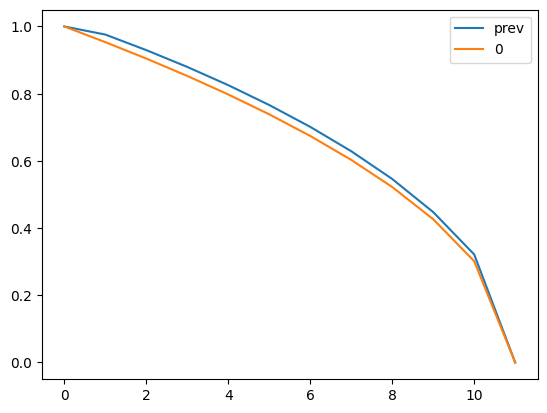

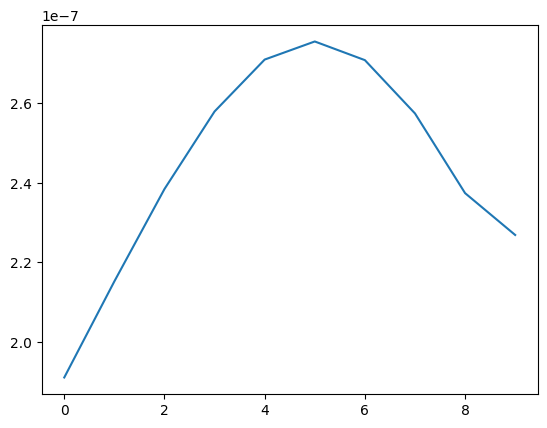

In [90]:
u1 = np.ones(1)
u1 = np.append(u1, W_prev)
u1 = np.append(u1, 0)

u0 = np.ones(1)
u0 = np.append(u0, W0)
u0 = np.append(u0, 0)
print(u1)

plt.plot(u1, label = 'prev')
plt.plot(u0, label = '0')
plt.legend()
plt.figure()
plt.plot(dW)